Приступим к обучению модели ARIMA

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 3-х параметров:
1. p — порядок компоненты AR
2. d — порядок интегрированного ряда
3. q — порядок компонетны MA

Согласно результатам теста Дики — Фуллера дневные ряды у нас стационарные, значит для них d примем за 0 (вообще модель для нестационарных рядов, но попробуем так ее адаптировать к нашим данным). Данное решение подсказали здесь: https://stats.stackexchange.com/a/205233.

Согласно (https://habr.com/ru/post/207160/) p и q определяется по коррелограмме частично автокорреляционной(PACF) и автокорреляционной(ACF) функций соответственно. Там они считались для ряда первых разностей, но т.к. наш ряд и так стационарный, посчитаем их для него самого.

In [22]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [23]:
rawData = pd.read_csv("drive/MyDrive/Adidas Sales/sales_simplified.csv")
rawData.drop("Unnamed: 0", axis=1, inplace=True)
rawData.sort_values(by="index", inplace=True)

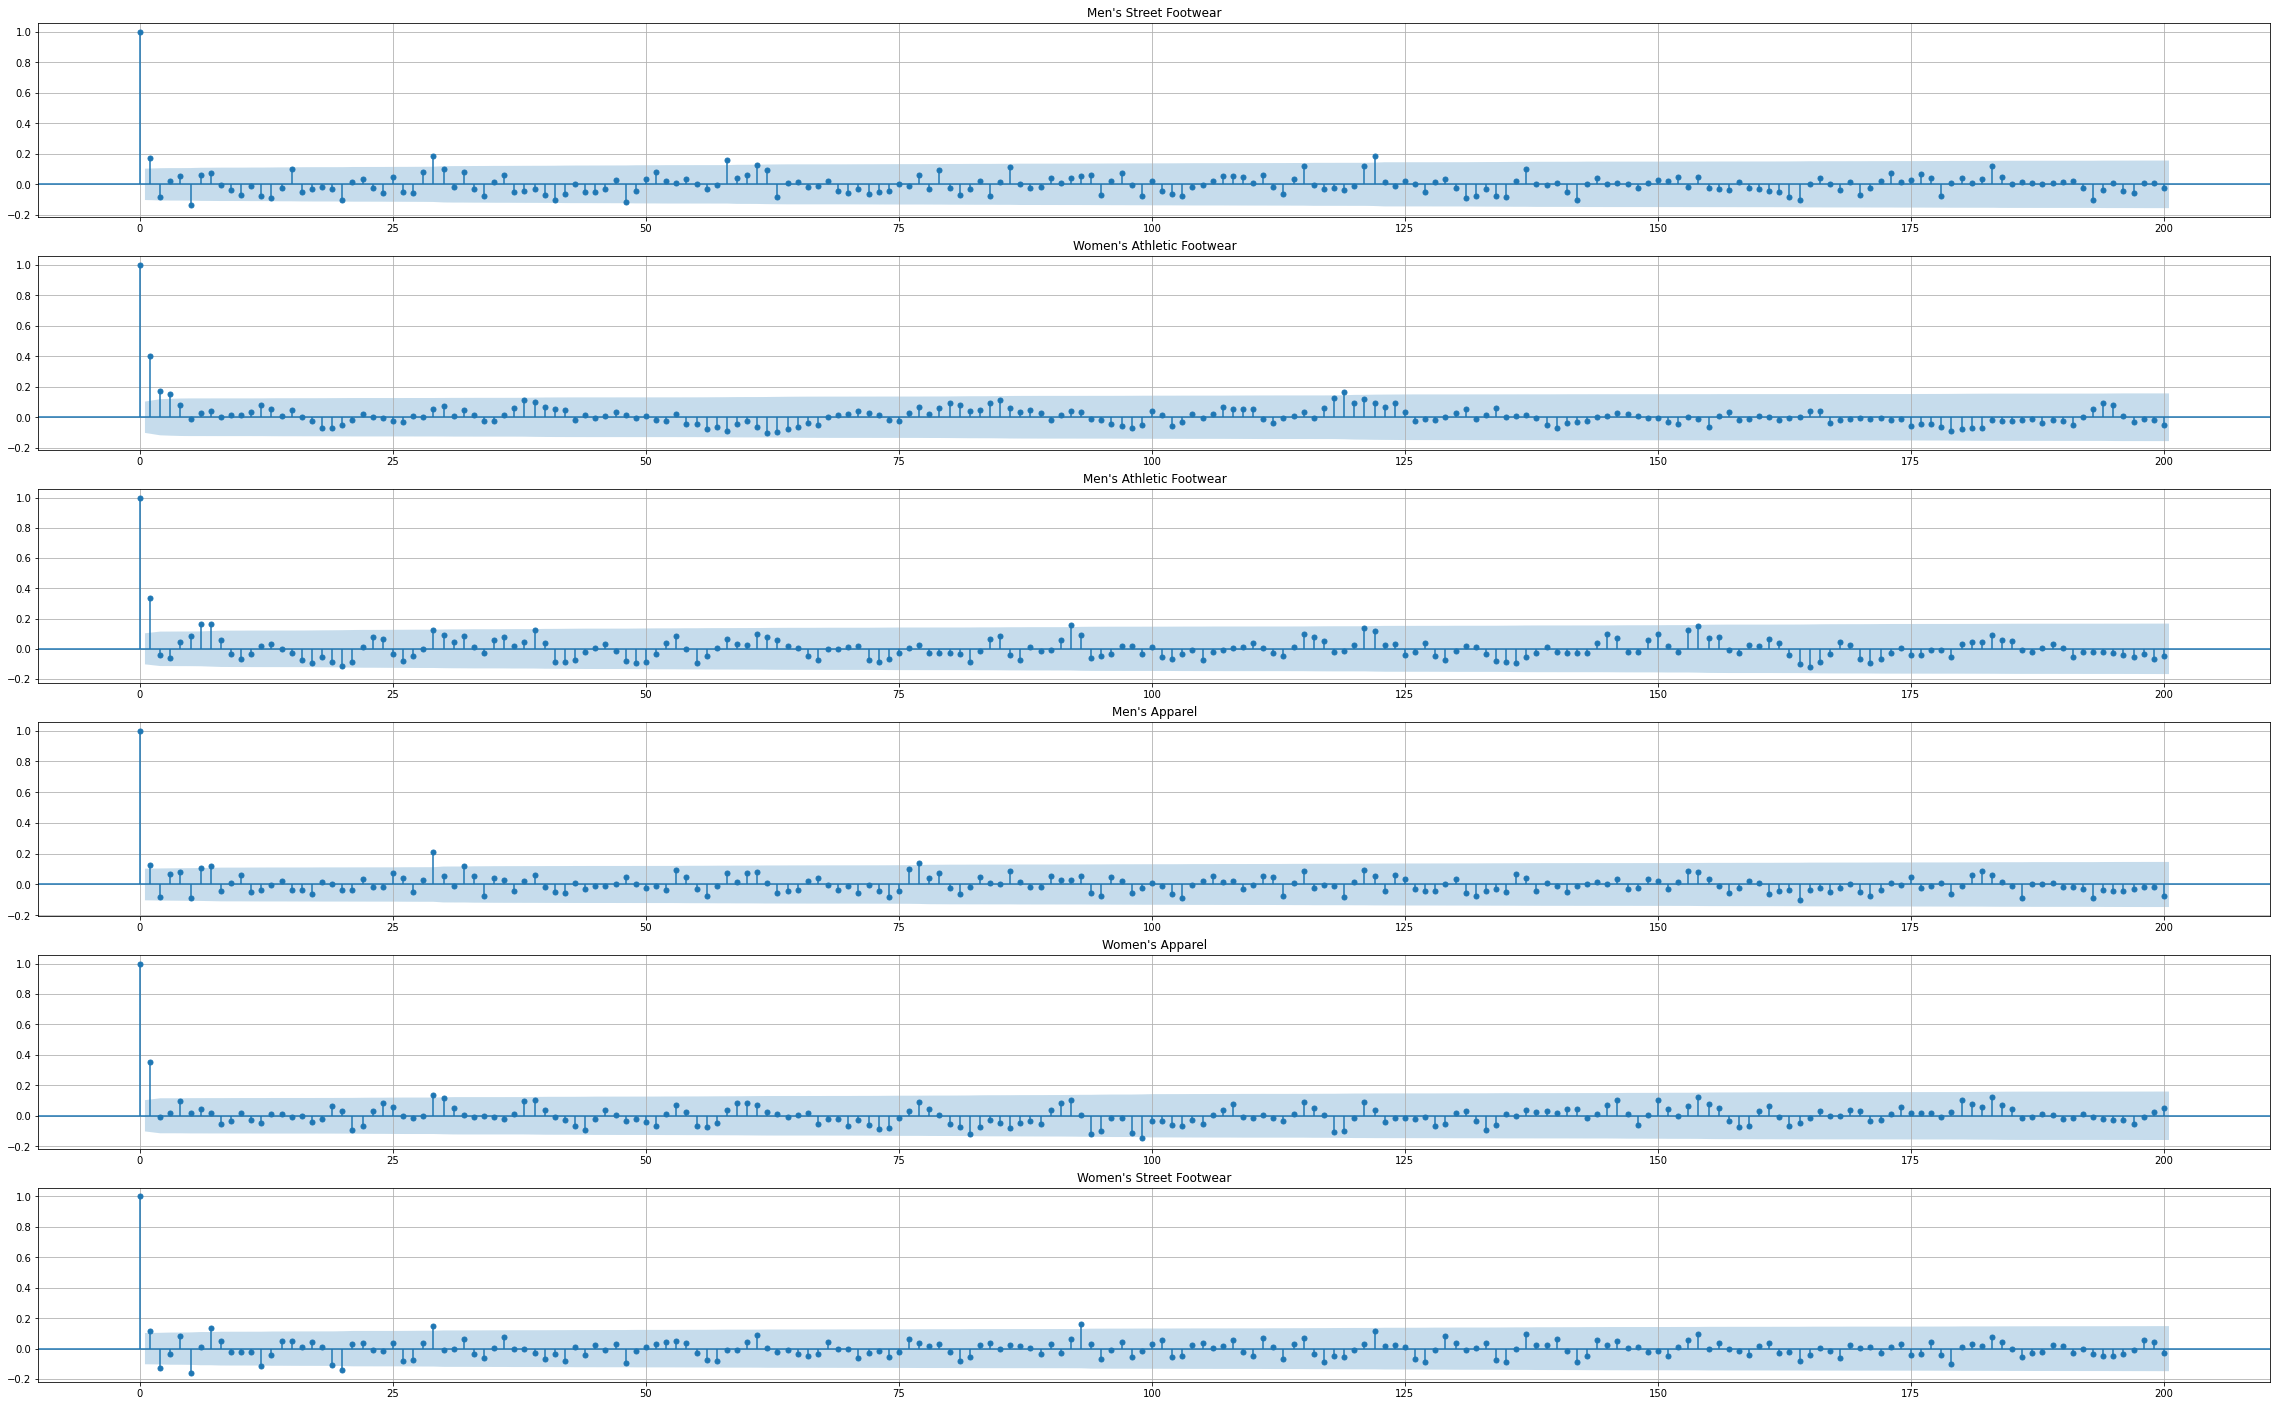

In [24]:
fig, axs = plt.subplots(6, 1, figsize=(40, 25))
for i, product in enumerate(rawData["Product"].unique()):
  Y = rawData[rawData["Product"] == product]["Units Sold"]
  sm.graphics.tsa.plot_acf(Y, lags=200, title=product, ax=axs[i])
  axs[i].grid()

Подсчитаем кол-во лагов, сильно отличных от 0. Здесь это не трудно: просто считаем кол-во лагов, выходящих за пределы синей зоны (доверительные интервалы дла каждого лага).

In [25]:
ACFResult = {
    "Men's Street Footwear": 5, 
    "Women's Athletic Footwear": 3, 
    "Women's Street Footwear": 6, 
    "Women's Apparel": 1, 
    "Men's Athletic Footwear": 3, 
    "Men's Apparel": 1
}

Выполним аналогичные манипуляции с частично автокорреляционной функцией.
Число лагов пришлось уменьшить, т.к. для 200 была ошибка.

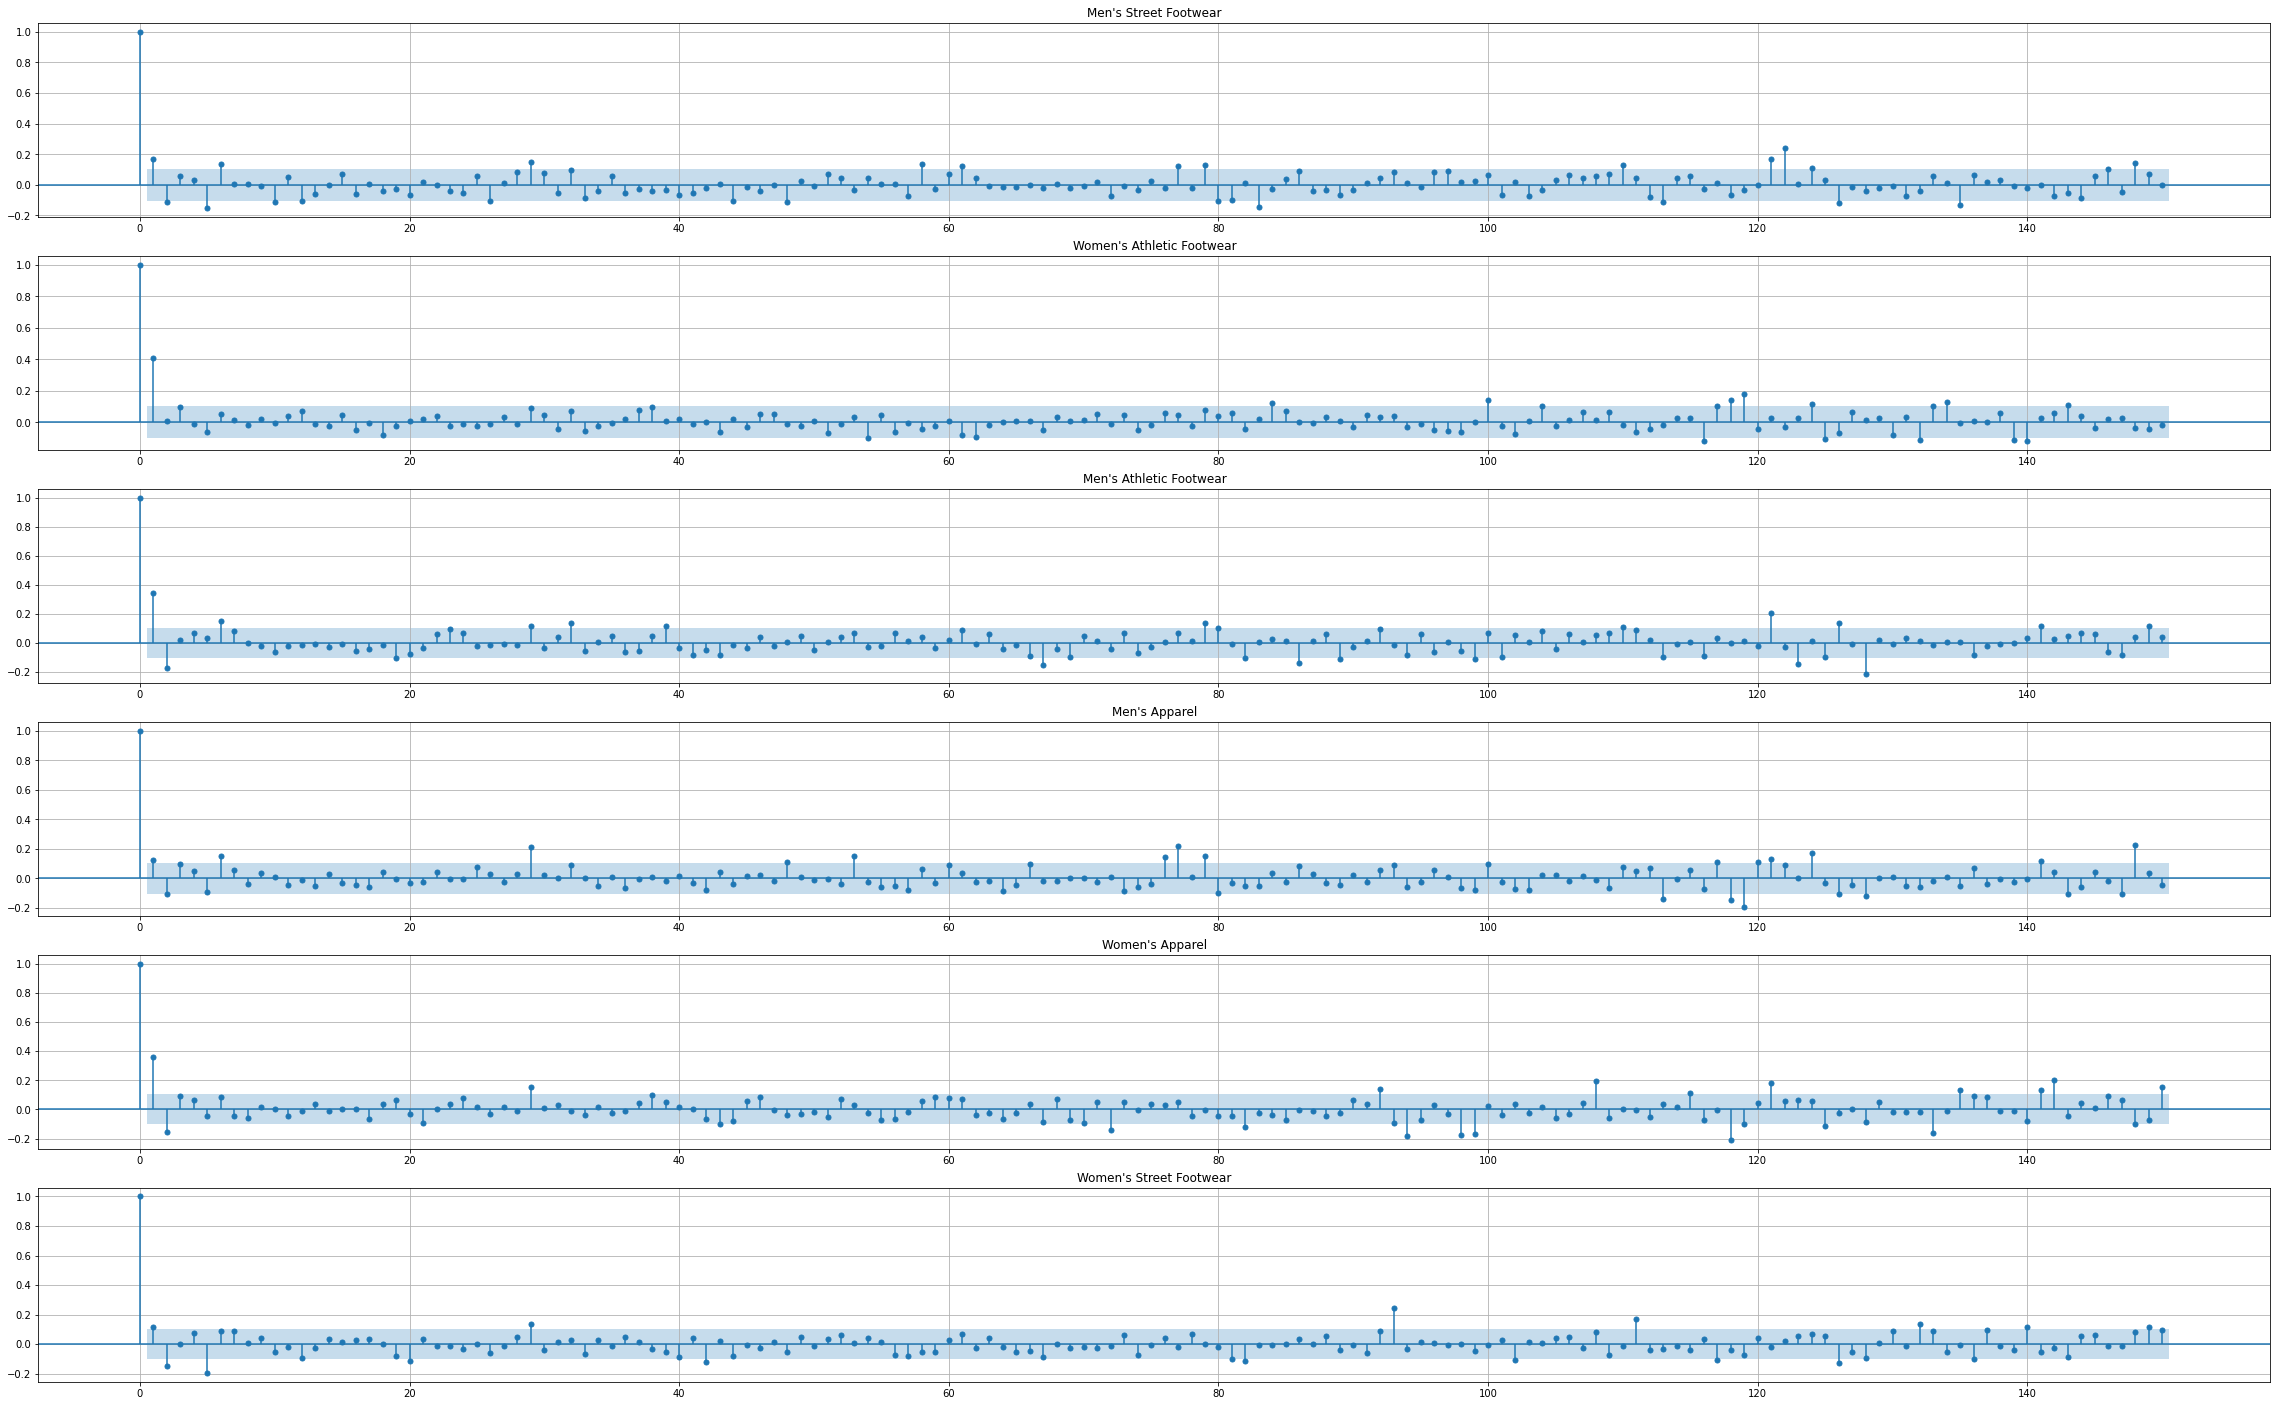

In [26]:
fig, axs = plt.subplots(6, 1, figsize=(40, 25))
for i, product in enumerate(rawData["Product"].unique()):
  Y = rawData[rawData["Product"] == product]["Units Sold"]
  sm.graphics.tsa.plot_pacf(Y, lags=150, title=product, ax=axs[i])
  axs[i].grid()

Аналогично посчитаем кол-во лагов.

In [27]:
PACFResult = {
    "Men's Street Footwear": 7, 
    "Women's Athletic Footwear": 6, 
    "Women's Street Footwear": 6, 
    "Women's Apparel": 13, 
    "Men's Athletic Footwear": 9, 
    "Men's Apparel": 10
}

Т.к. параметры p и q были выбраны на глаз найдем подберем наилучшие значения методом оптимизации гипперпараметров обучаемой модели.

Т.к. простой перебор по сетке займет слишком много времени, а случайный поиск не гарантирует лучшего решения, воспользуемся алгоритмом TPE.

In [28]:
# Т.к. модуля optuna в Google Colab изначально нет, произведем его установку
%pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
# Это наша функция ошибки (RMSE)
from sklearn.metrics import mean_squared_error
# Это наш оптимизатор
import optuna
import math
import pickle as pkl

In [30]:
import warnings
''' При обучении очень часто возникает следующее предупреждение "/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated 
and will be removed in a future version. date_key = Timestamp(key, freq=base_index.freq)" Блокируем ее!'''
warnings.filterwarnings("ignore", category=FutureWarning)

Установленный оптимизатор настроен на работу с функциями, поэтому создадим функцию-обертку

In [31]:
# Наш класс-обертка
class ARIMAEstimator:
  def __init__(self, train, test, p_max, d_max, q_max):
    self.train = train
    self.test = test
    self.p_max = p_max if p_max > 0 else 1
    self.d_max = d_max if d_max > 0 else 1
    self.q_max = q_max if q_max > 0 else 1
  
  def __call__(self, trial):
    p_value = trial.suggest_int("p_value", 1, self.p_max)
    d_value = trial.suggest_int("d_value", 0, self.d_max)
    q_value = trial.suggest_int("q_value", 1, self.q_max)
    model = ARIMA(self.train, order=(p_value, d_value, q_value))
    result = model.fit()
    pred = result.get_prediction(self.test.index.min(), self.test.index.max()).predicted_mean
    return mean_squared_error(self.test, pred, squared=False)

In [32]:
# Функции, чтобы минмизировать повторение кода
def trainTestSplit(data, product, treshold, freq="D"):
  buffer = data[data["Product"] == product].copy().drop("Product", axis=1)
  buffer.index = pd.DatetimeIndex(buffer["index"].values, freq="D")
  if freq != "D":
    buffer = buffer.resample(freq, kind="timestamp").mean()  
  buffer = buffer["Units Sold"]
  train, test = buffer[: treshold], buffer[treshold :]
  return train, test

def performEstiation(train, test, p_max, d_max, q_max):
  estimator = ARIMAEstimator(train, test, p_max, d_max, q_max)
  study = optuna.create_study(direction="minimize")
  study.optimize(estimator, n_trials=20)
  p_value, d_value, q_value = study.best_params["p_value"], study.best_params["d_value"], study.best_params["q_value"]
  rmse = study.best_value
  return {"RMSE":rmse, "(p,d,q)":(p_value, 0, q_value)}

In [ ]:
# Выполни обучение моделей на своем ПК
bestModels = {}
treshold = "2021-11-01"
for product in rawData["Product"].unique():
  if len(bestModels) > 0:
    with open("drive/MyDrive/Adidas Sales/ARIMA_best_daily_usual.pkl", "wb") as file:
      pkl.dump(bestModels, file)
  train, test = trainTestSplit(rawData, product, treshold)
  bestParams = performEstiation(train, test, ACFResult[product], 0, PACFResult[product])
  if (product not in bestModels) or (bestParams["RMSE"] < bestModels[product]["RMSE"]):
    print("Product: {} (p,d,q): {} rmse: {}".format(product, bestParams["(p,d,q)"], bestParams["RMSE"]))
    bestModels[product] = bestParams

In [ ]:
for product in bestModels:
  print("Product: {} (p,d,q): {} rmse: {}".format(product, bestModels[product]["(p,d,q)"], bestModels[product]["RMSE"]))

Повторим те же действия для недельных данных

Для данных, усредненных по неделям, тест говорил о стационарности, значит, d = 0.

Выполним анализ ACF PACF для усредненных по неделе (количество лагов пришлось уменьшить по аналогичной причине, что в прошлый раз)

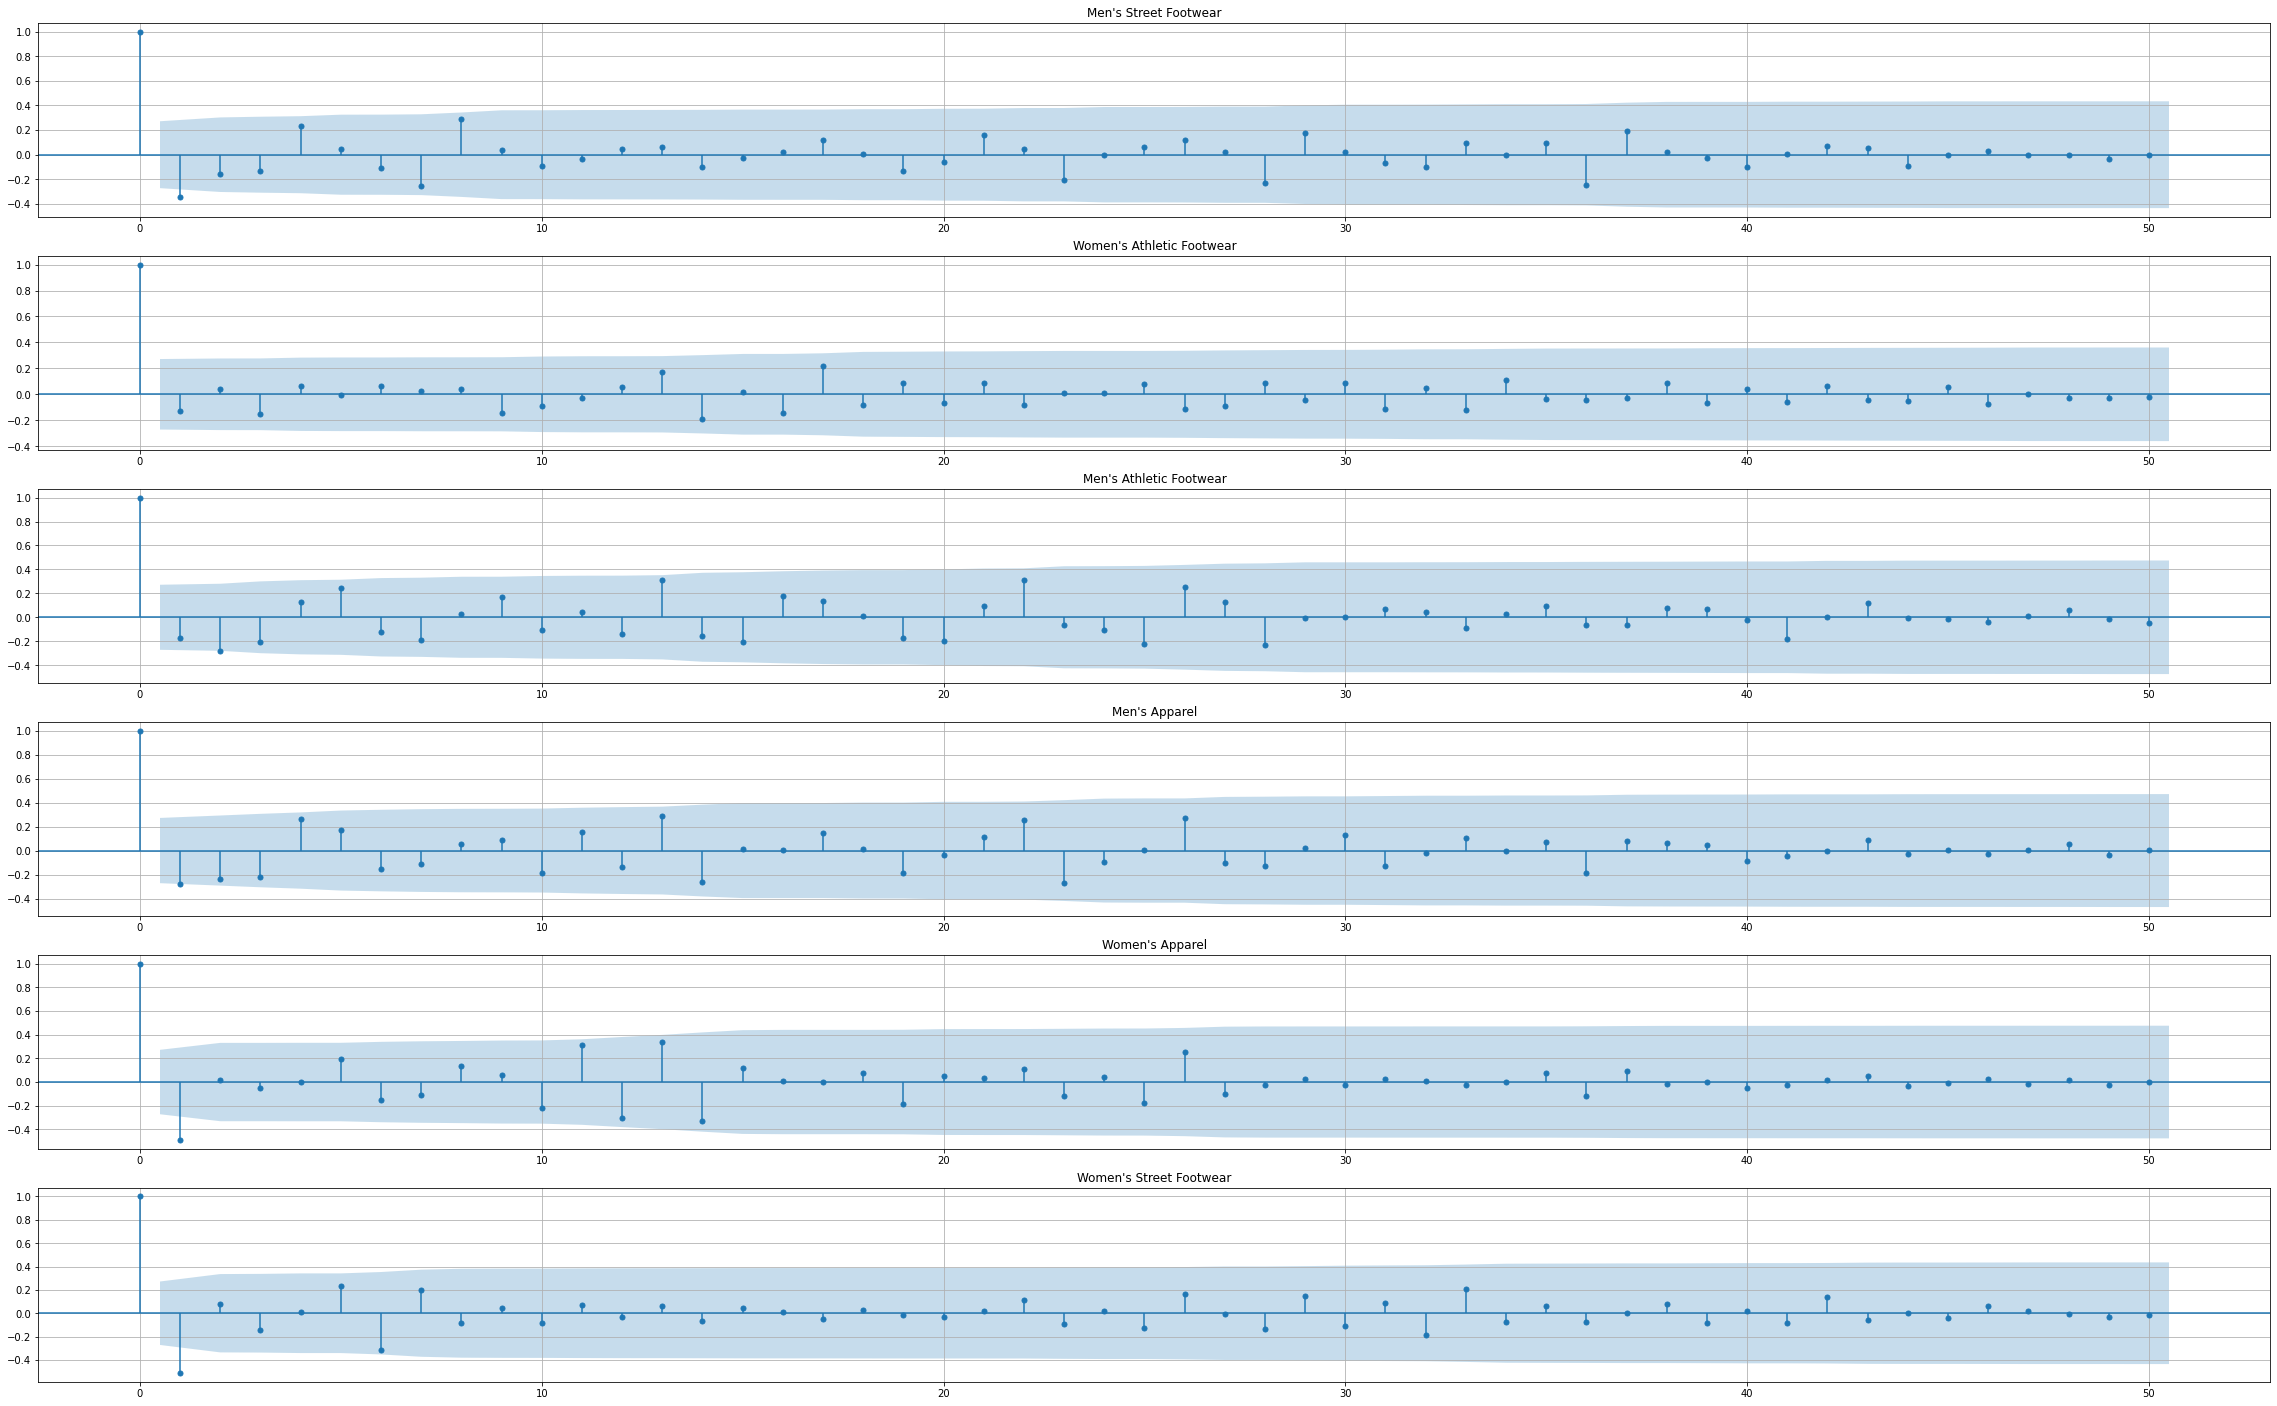

In [33]:
fig, axs = plt.subplots(6, 1, figsize=(40, 25))
for i, product in enumerate(rawData["Product"].unique()):
  buffer = rawData[rawData["Product"] == product].copy()
  buffer["index"] =  pd.to_datetime(buffer["index"])
  buffer = buffer.sort_values(by="index").set_index("index").drop("Product", axis=1)
  buffer = buffer.resample("W", kind="timestamp").mean().diff().dropna()
  sm.graphics.tsa.plot_acf(buffer, lags=50, title=product, ax=axs[i])
  axs[i].grid()

In [34]:
ACFWeekResult = {
    "Men's Street Footwear": 1,
    "Women's Athletic Footwear": 0,
    "Women's Street Footwear": 1,
    "Women's Apparel": 1, 
    "Men's Athletic Footwear": 0,
    "Men's Apparel": 0
}

Теперь PACF

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


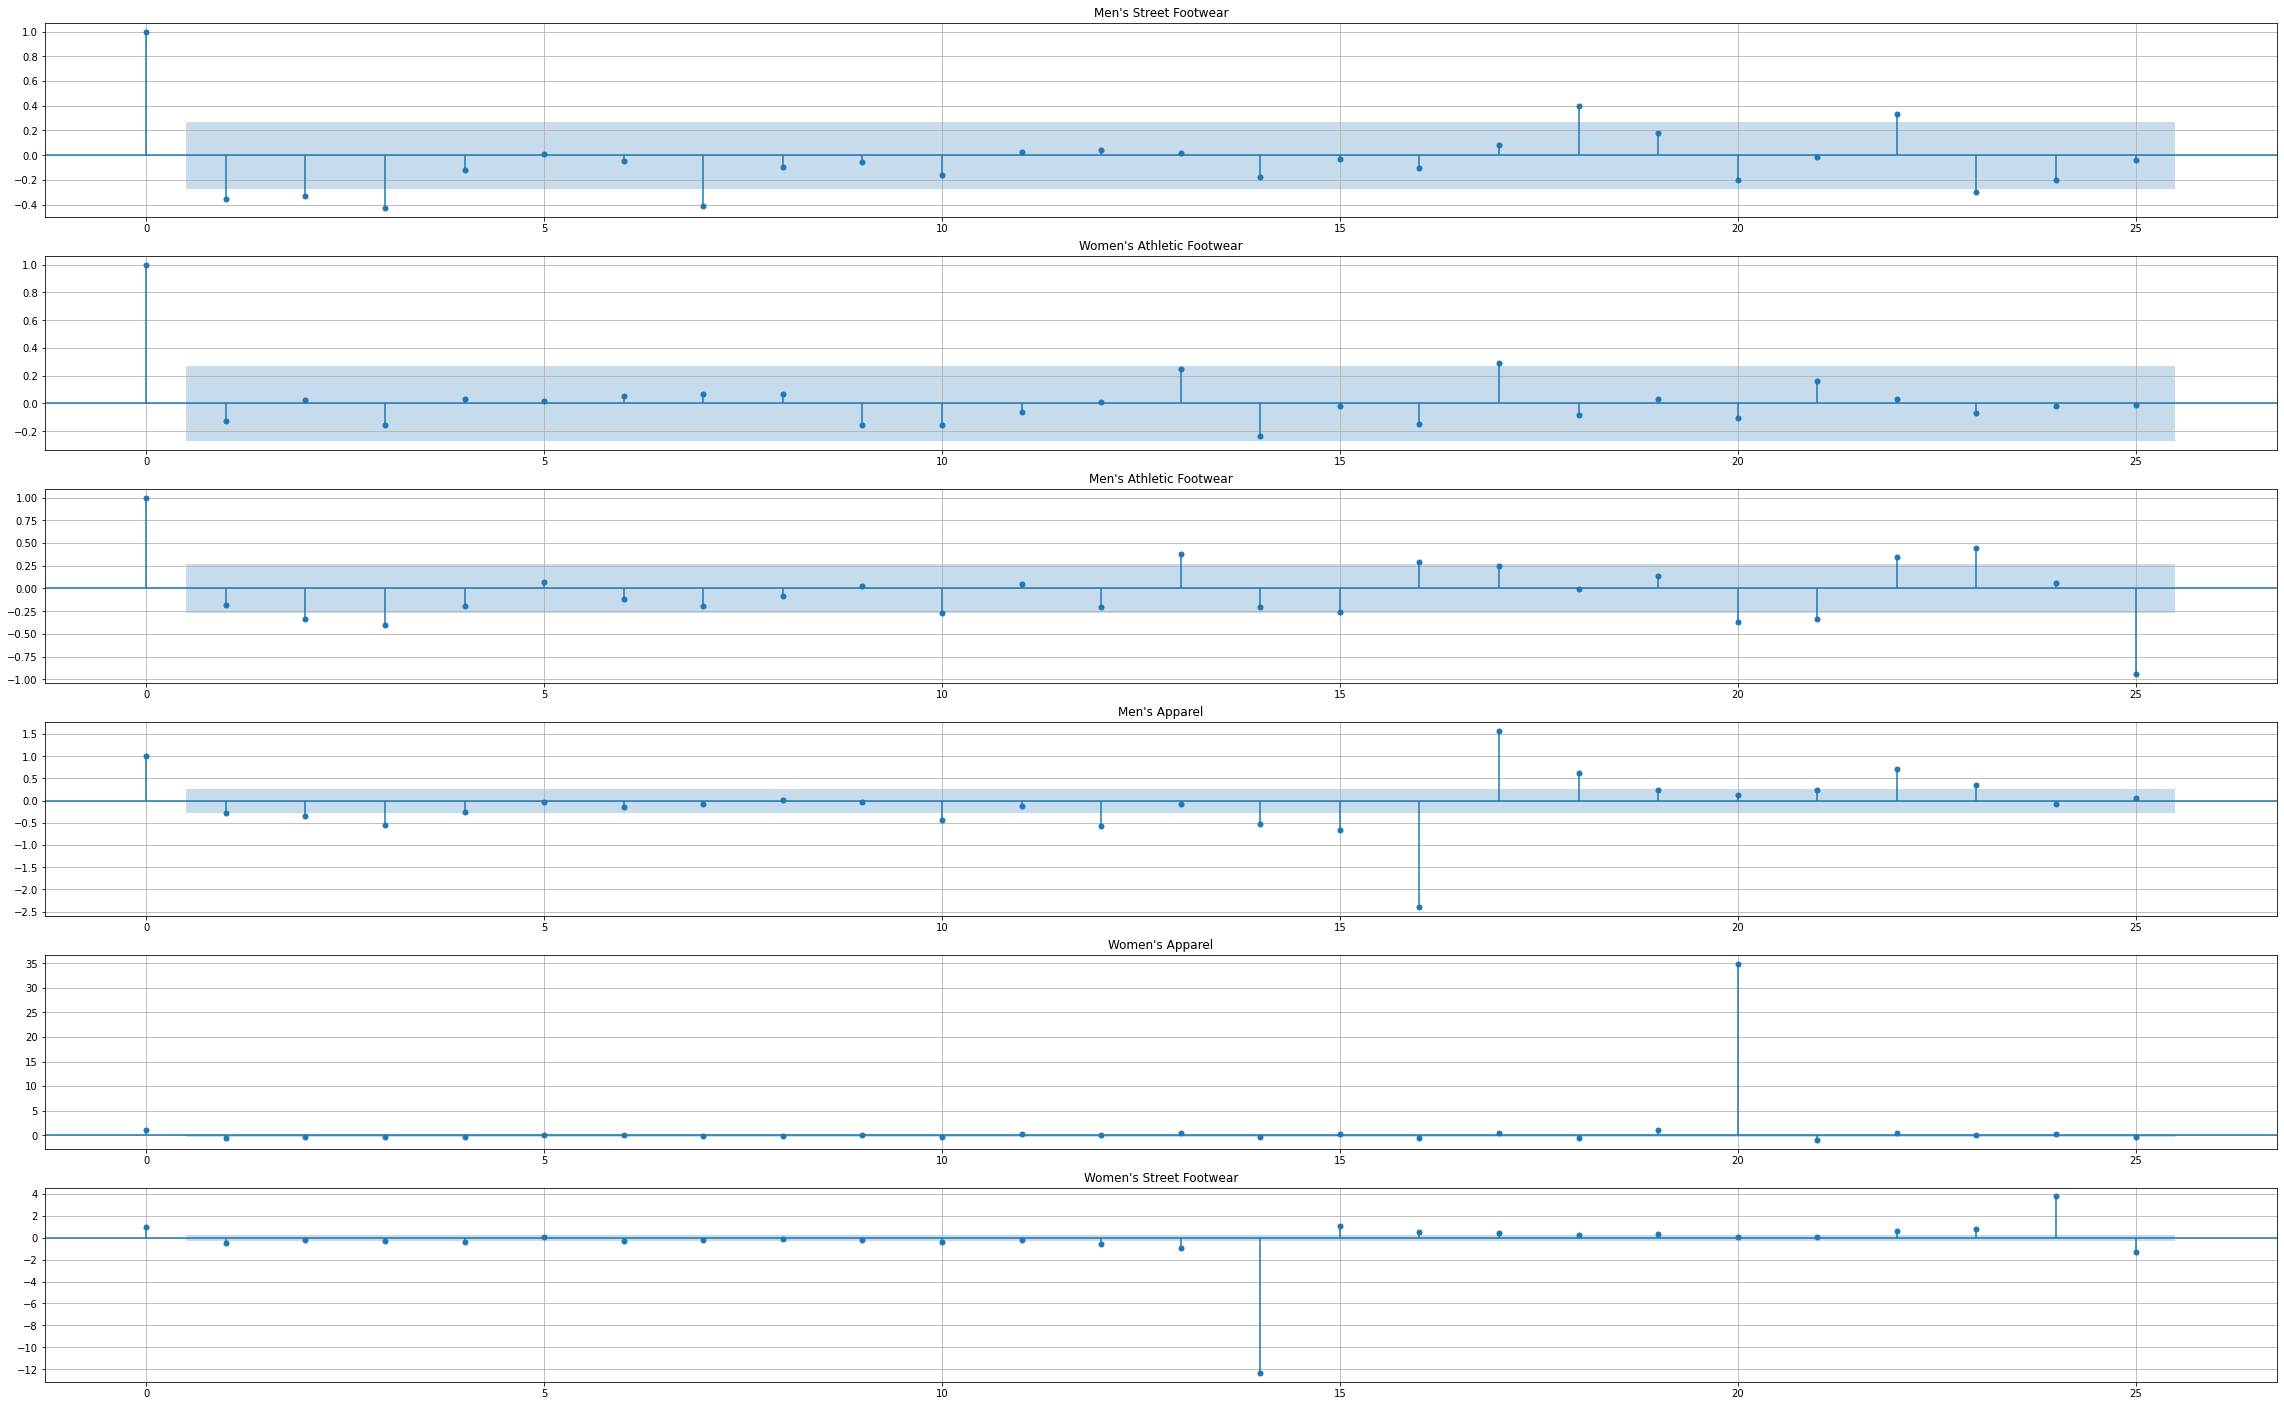

In [35]:
fig, axs = plt.subplots(6, 1, figsize=(40, 25))
for i, product in enumerate(rawData["Product"].unique()):
  buffer = rawData[rawData["Product"] == product].copy()
  buffer["index"] =  pd.to_datetime(buffer["index"])
  buffer = buffer.sort_values(by="index").set_index("index").drop("Product", axis=1)
  buffer = buffer.resample("W", kind="timestamp").mean().diff().dropna()
  sm.graphics.tsa.plot_pacf(buffer, lags=25, title=product, ax=axs[i])
  axs[i].grid()

In [36]:
PACFWeekResult = {
    "Men's Street Footwear": 7,
    "Women's Athletic Footwear": 1,
    "Women's Street Footwear": 4,
    "Women's Apparel": 1, 
    "Men's Athletic Footwear": 8,
    "Men's Apparel": 8
}

Приступим к обучению

In [37]:
# Выполни обучение моделей на своем ПК
bestModels = {}
treshold = "2021-10-24"
for product in rawData["Product"].unique():
  if len(bestModels) > 0:
    with open("drive/MyDrive/Adidas Sales/ARIMA_best_weekly_usual.pkl", "wb") as file:
      pkl.dump(bestModels, file)
  train, test = trainTestSplit(rawData, product, treshold, freq="W")
  bestParams = performEstiation(train, test, ACFWeekResult[product], 1, PACFWeekResult[product])
  if (product not in bestModels) or (bestParams["RMSE"] < bestModels[product]["RMSE"]):
    print("Product: {} (p,d,q): {} rmse: {}".format(product, bestParams["(p,d,q)"], bestParams["RMSE"]))
    bestModels[product] = bestParams

[I 2023-02-25 18:36:13,765] A new study created in memory with name: no-name-4cfc8de6-bbb7-41bf-8587-4df65af52dfd
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
[I 2023-02-25 18:36:15,122] Trial 0 finished with value: 537.9021984720043 and parameters: {'p_value': 1, 'd_value': 1, 'q_value': 5}. Best is trial 0 with value: 537.9021984720043.
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2023-02-25 18:36:16,312] Trial 1 finished with value: 508.35029975049844 and parameters: {'p_value': 1, 'd_value': 0, 'q_value': 7}. Best is trial 1 with value: 508.35029975049844.
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566:

Product: Men's Street Footwear (p,d,q): (1, 0, 3) rmse: 434.8208226426749


[I 2023-02-25 18:36:20,520] Trial 1 finished with value: 1003.6532829923228 and parameters: {'p_value': 1, 'd_value': 1, 'q_value': 1}. Best is trial 1 with value: 1003.6532829923228.
[I 2023-02-25 18:36:20,607] Trial 2 finished with value: 1038.6542365239843 and parameters: {'p_value': 1, 'd_value': 0, 'q_value': 1}. Best is trial 1 with value: 1003.6532829923228.
[I 2023-02-25 18:36:20,726] Trial 3 finished with value: 1038.6542365239843 and parameters: {'p_value': 1, 'd_value': 0, 'q_value': 1}. Best is trial 1 with value: 1003.6532829923228.
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
[I 2023-02-25 18:36:20,813] Trial 4 finished with value: 1003.6532829923228 and parameters: {'p_value': 1, 'd_value': 1, 'q_value': 1}. Best is trial 1 with value: 1003.6532829923228.
/usr/local/lib/python3.8/dist-pack

Product: Women's Athletic Footwear (p,d,q): (1, 0, 1) rmse: 1003.6532829923228


[I 2023-02-25 18:36:22,625] Trial 1 finished with value: 302.21872655684837 and parameters: {'p_value': 1, 'd_value': 0, 'q_value': 3}. Best is trial 1 with value: 302.21872655684837.
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2023-02-25 18:36:23,077] Trial 2 finished with value: 415.62835664572196 and parameters: {'p_value': 1, 'd_value': 1, 'q_value': 7}. Best is trial 1 with value: 302.21872655684837.
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maxi

Product: Men's Athletic Footwear (p,d,q): (1, 0, 8) rmse: 273.6007284627189


[I 2023-02-25 18:36:35,634] Trial 1 finished with value: 167.81964755663518 and parameters: {'p_value': 1, 'd_value': 0, 'q_value': 3}. Best is trial 1 with value: 167.81964755663518.
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2023-02-25 18:36:36,085] Trial 2 finished with value: 140.81011627798352 and parameters: {'p_value': 1, 'd_value': 1, 'q_value': 7}. Best is trial 2 with value: 140.81011627798352.
[I 2023-02-25 18:36:36,239] Trial 3 finished with value: 168.42842601936803 and parameters: {'p_value': 1, 'd_value': 1, 'q_value': 2}. Best is trial 2 with value: 140.8101162779835

Product: Men's Apparel (p,d,q): (1, 0, 7) rmse: 140.81011627798352


[I 2023-02-25 18:36:43,405] Trial 1 finished with value: 272.57472032119233 and parameters: {'p_value': 1, 'd_value': 0, 'q_value': 1}. Best is trial 1 with value: 272.57472032119233.
[I 2023-02-25 18:36:43,504] Trial 2 finished with value: 349.8902417538132 and parameters: {'p_value': 1, 'd_value': 1, 'q_value': 1}. Best is trial 1 with value: 272.57472032119233.
[I 2023-02-25 18:36:43,741] Trial 3 finished with value: 272.57472032119233 and parameters: {'p_value': 1, 'd_value': 0, 'q_value': 1}. Best is trial 1 with value: 272.57472032119233.
[I 2023-02-25 18:36:43,835] Trial 4 finished with value: 349.8902417538132 and parameters: {'p_value': 1, 'd_value': 1, 'q_value': 1}. Best is trial 1 with value: 272.57472032119233.
[I 2023-02-25 18:36:43,927] Trial 5 finished with value: 349.8902417538132 and parameters: {'p_value': 1, 'd_value': 1, 'q_value': 1}. Best is trial 1 with value: 272.57472032119233.
[I 2023-02-25 18:36:44,032] Trial 6 finished with value: 349.8902417538132 and para

Product: Women's Apparel (p,d,q): (1, 0, 1) rmse: 272.57472032119233


[I 2023-02-25 18:36:47,775] Trial 0 finished with value: 236.3807096222784 and parameters: {'p_value': 1, 'd_value': 0, 'q_value': 4}. Best is trial 0 with value: 236.3807096222784.
[I 2023-02-25 18:36:48,032] Trial 1 finished with value: 245.42155258327395 and parameters: {'p_value': 1, 'd_value': 0, 'q_value': 1}. Best is trial 0 with value: 236.3807096222784.
[I 2023-02-25 18:36:48,316] Trial 2 finished with value: 254.82615368442296 and parameters: {'p_value': 1, 'd_value': 0, 'q_value': 2}. Best is trial 0 with value: 236.3807096222784.
[I 2023-02-25 18:36:48,589] Trial 3 finished with value: 236.3807096222784 and parameters: {'p_value': 1, 'd_value': 0, 'q_value': 4}. Best is trial 0 with value: 236.3807096222784.
[I 2023-02-25 18:36:48,790] Trial 4 finished with value: 264.84807257506316 and parameters: {'p_value': 1, 'd_value': 1, 'q_value': 4}. Best is trial 0 with value: 236.3807096222784.
[I 2023-02-25 18:36:48,870] Trial 5 finished with value: 269.6628315164715 and paramete

Product: Women's Street Footwear (p,d,q): (1, 0, 4) rmse: 236.3807096222784


In [38]:
for product in bestModels:
  print("Product: {} (p,d,q): {} rmse: {}".format(product, bestModels[product]["(p,d,q)"], bestModels[product]["RMSE"]))

Product: Men's Street Footwear (p,d,q): (1, 0, 3) rmse: 434.8208226426749
Product: Women's Athletic Footwear (p,d,q): (1, 0, 1) rmse: 1003.6532829923228
Product: Men's Athletic Footwear (p,d,q): (1, 0, 8) rmse: 273.6007284627189
Product: Men's Apparel (p,d,q): (1, 0, 7) rmse: 140.81011627798352
Product: Women's Apparel (p,d,q): (1, 0, 1) rmse: 272.57472032119233
Product: Women's Street Footwear (p,d,q): (1, 0, 4) rmse: 236.3807096222784


Формирование бейзлайна по моделям ARIMA завершено.